In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

# import os
# print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

In [2]:
a1 = pd.read_csv('all-the-news/articles1.csv',index_col=0)
a2 = pd.read_csv('all-the-news/articles2.csv',index_col=0)
a3 = pd.read_csv('all-the-news/articles3.csv',index_col=0)

In [3]:
df = pd.concat([a1,a2,a3])

In [4]:
# save memory
del a1, a2, a3

In [5]:
df.head()

,id,title,publication,author,date,year,month,url,content
0,17283,House Republicans Fret About Winning Their Hea...,New York Times,Carl Hulse,2016-12-31,2016.0,12.0,NaN,WASHINGTON — Congressional Republicans have...
1,17284,Rift Between Officers and Residents as Killing...,New York Times,Benjamin Mueller and Al Baker,2017-06-19,2017.0,6.0,NaN,"After the bullet shells get counted, the blood..."
2,17285,"Tyrus Wong, ‘Bambi’ Artist Thwarted by Racial ...",New York Times,Margalit Fox,2017-01-06,2017.0,1.0,NaN,"When Walt Disney’s “Bambi” opened in 1942, cri..."
3,17286,"Among Deaths in 2016, a Heavy Toll in Pop Musi...",New York Times,William McDonald,2017-04-10,2017.0,4.0,NaN,"Death may be the great equalizer, but it isn’t..."
4,17287,Kim Jong-un Says North Korea Is Preparing to T...,New York Times,Choe Sang-Hun,2017-01-02,2017.0,1.0,NaN,"SEOUL, South Korea — North Korea’s leader, ..."


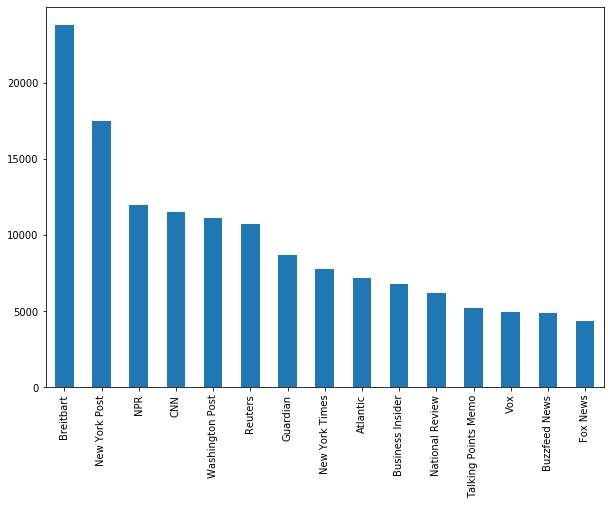

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(10,7))
df.publication.value_counts().plot(kind='bar')

In [7]:
doc = df.loc[0,'content']

In [8]:
import spacy
from spacy import displacy
nlp = spacy.load('en')

In [9]:
doc = nlp(doc)

In [10]:
displacy.render(doc,style='ent',jupyter=True)

In [11]:
from tqdm import tqdm, tqdm_notebook

In [12]:
nlp = spacy.load('en',
                 disable=['parser', 
                          'tagger',
                          'textcat'])

conda install  ipywidgets
==> WARNING: A newer version of conda exists. <==
  current version: 4.7.5
  latest version: 4.7.10

Please update conda by running

    $ conda update -n base conda


In [15]:
frames = []
for i in tqdm_notebook(range(1000)):
    doc = df.loc[i,'content']
    text_id = df.loc[i,'id']
    doc = nlp(doc)
    ents = [(e.text, e.start_char, e.end_char, e.label_) 
            for e in doc.ents 
            if len(e.text.strip(' -—')) > 0]
    frame = pd.DataFrame(ents)
    frame['id'] = text_id
    frames.append(frame)

In [16]:
npf = pd.concat(frames)

In [17]:
npf.head()

,0,1,2,3,id
0,WASHINGTON,0,10,GPE,17283
1,Obama,116,121,PERSON,17283
2,Trump,167,172,ORG,17283
3,billions of dollars,317,336,MONEY,17283
4,House,398,403,ORG,17283


In [18]:
npf.columns = ['Text','Start','Stop','Type','id']

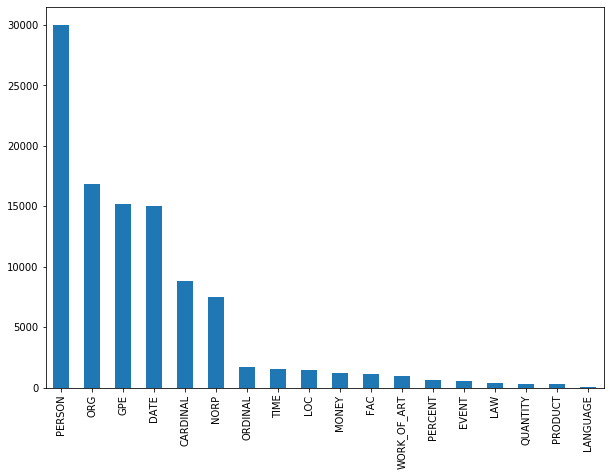

In [19]:
plt.figure(figsize=(10,7))
npf.Type.value_counts().plot(kind='bar')

In [20]:
orgs = npf[npf.Type == 'ORG']

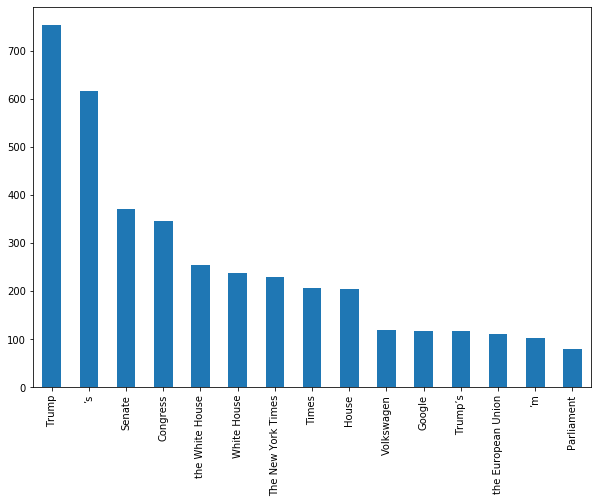

In [21]:
plt.figure(figsize=(10,7))
orgs.Text.value_counts()[:15].plot(kind='bar')

In [22]:
orgs.groupby(['id','Text']).size()

id     Text                                                              
17283  Capitol Hill                                                           1
       Congress                                                               5
       House                                                                 15
       The Justice Department                                                 1
       The White House                                                        1
       Trump                                                                  7
       the Treasury Department                                                1
       the United States Court of Appeals                                     1
       the White House                                                        1
       ’s                                                                     1
17284  District Attorney’s                                                    1
       Hennessy                               

# Fine tuning SpaCy NER

In [25]:
import spacy
import random

In [29]:
TRAIN_DATA = [
    ('Who is Shaka Khan?', {
        'entities': [(7, 17, 'PERSON')]
    }),
    ('I like London and Berlin.', {
        'entities': [(7, 13, 'LOC'), (18, 24, 'LOC')]
    })
]

In [30]:
nlp = spacy.load('en')

In [31]:
# create the built-in pipeline components and add them to the pipeline
# nlp.create_pipe works for built-ins that are registered with spaCy
if 'ner' not in nlp.pipe_names:
    ner = nlp.create_pipe('ner')
    nlp.add_pipe(ner, last=True)
# otherwise, get it so we can add labels
else:
    ner = nlp.get_pipe('ner')

In [32]:
# add labels
for _, annotations in TRAIN_DATA:
    for ent in annotations.get('entities'):
        ner.add_label(ent[2])

In [33]:
n_iter = 5

# get names of other pipes to disable them during training
other_pipes = [pipe for pipe in nlp.pipe_names if pipe != 'ner']

with nlp.disable_pipes(*other_pipes):  # only train NER
    optimizer = nlp._optimizer 
    if not nlp._optimizer:
        optimizer = nlp.begin_training()
    
    for itn in range(n_iter):
        random.shuffle(TRAIN_DATA)
        losses = {}
        for text, annotations in TRAIN_DATA:
            nlp.update(
                [text],  # batch of texts
                [annotations],  # batch of annotations
                drop=0.5,  # dropout - make it harder to memorise data
                sgd=optimizer,  # callable to update weights
                losses=losses)
        print(losses)

{'ner': 6.144098000265785}
{'ner': 3.8787198366078286}
{'ner': 3.9736206351772836}
{'ner': 7.74406930079931}
{'ner': 3.557254644804605}


In [34]:
# test the trained model
for text, _ in TRAIN_DATA:
    doc = nlp(text)
    print('Entities', [(ent.text, ent.label_) for ent in doc.ents])
    print('Tokens', [(t.text, t.ent_type_, t.ent_iob) for t in doc])


Entities [('Shaka Khan', 'PERSON')]
Tokens [('Who', '', 2), ('is', '', 2), ('Shaka', 'PERSON', 3), ('Khan', 'PERSON', 1), ('?', '', 2)]
Entities [('London', 'GPE'), ('Berlin', 'GPE')]
Tokens [('I', '', 2), ('like', '', 2), ('London', 'GPE', 3), ('and', '', 2), ('Berlin', 'GPE', 3), ('.', '', 2)]


# Part-of-Speech (POS) tagging

In [42]:
import spacy
from spacy import displacy
nlp = spacy.load('en')

doc = 'Google to buy Apple'
doc = nlp(doc)
displacy.render(doc,style='dep',jupyter=True, options={'distance':120})

In [38]:
for chunk in doc.noun_chunks:
    print(chunk.text,'|' , chunk.root.text,'|', chunk.root.dep_,'|',
          chunk.root.head.text)

Google | Google | nsubj | buy
Apple | Apple | dobj | buy


In [39]:
for token in doc:
    print(token.text,'|', token.lemma_,'|', token.pos_,'|', token.tag_,'|', token.dep_,'|',
          token.shape_,'|', token.is_alpha,'|', token.is_stop)

Google | Google | PROPN | NNP | nsubj | Xxxxx | True | False
to | to | PART | TO | aux | xx | True | True
buy | buy | VERB | VB | ROOT | xxx | True | False
Apple | Apple | PROPN | NNP | dobj | Xxxxx | True | False


# Rule based matching

In [43]:
import spacy
from spacy.matcher import Matcher

nlp = spacy.load('en')

In [49]:
pattern = [{'LOWER': 'hello'}, {'IS_PUNCT': True}, {'LOWER': 'world'}]

matcher = Matcher(nlp.vocab)
matcher.add('HelloWorld', None, pattern)

doc = nlp(u'Hello, world! Hello world!, hello! world!')
matches = matcher(doc)

In [50]:
matches

[(15578876784678163569, 0, 3), (15578876784678163569, 8, 11)]

In [51]:
doc[0:3]

Hello, world

In [53]:
doc[8:11]

hello! world

# Adding custom functions to matchers

In [56]:
df.title = df.title.fillna('')

In [57]:
np.where(df.content.str.contains('iPhone'))

(array([    14,     51,     71, ..., 142261, 142528, 142555]),)

In [58]:
df.loc[14]

id                                                         17297
title          Turning Your Vacation Photos Into Works of Art...
publication                                       New York Times
author                                      Stephanie Rosenbloom
date                                                  2017-04-14
year                                                        2017
month                                                          4
url                                                          NaN
content        It’s the season for family travel and photos  ...
Name: 14, dtype: object

In [59]:
import spacy
from spacy.matcher import Matcher

nlp = spacy.load('en')
matcher = Matcher(nlp.vocab)

In [60]:
# Get the hash of the word 'PRODUCT'. This is required to set an entity.
PRODUCT = nlp.vocab.strings['PRODUCT']

def add_product_ent(matcher, doc, i, matches):
    # Get the current match and create tuple of entity label, start and end.
    # Append entity to the doc's entity. (Don't overwrite doc.ents!)
    match_id, start, end = matches[i]
    doc.ents += ((PRODUCT, start, end),)

pattern1 = [{'LOWER': 'iphone'}]
pattern2 = [{'ORTH': 'iPhone'}, {'IS_DIGIT': True}]

matcher.add('iPhone', add_product_ent,pattern1, pattern2)

In [62]:
doc = nlp(df.content.iloc[14])
#matcher(doc)

In [63]:
matches = matcher(doc)

# Adding the matcher to the pipeline

In [65]:
def matcher_component(doc):
    matches = matcher(doc)
    return doc

In [66]:
nlp.add_pipe(matcher_component,last=True)

In [67]:
displacy.render(doc,style='ent',jupyter=True)

# Regular expressions Regex

In [68]:
import re

In [69]:
pattern = 'NL[0-9]{9}B[0-9]{2}'

In [70]:
my_string = 'ING Bank N.V. BTW:NL003028112B01'

In [71]:
re.findall(pattern,my_string)

['NL003028112B01']

In [72]:
match = re.search(pattern,my_string)

In [73]:
match.span()

(18, 32)